# Ada - Milestone 2





## Installations

In [ ]:
!pip install pandas==1.0.5

In [ ]:
pip install tqdm

In [ ]:
!pip install newspaper3k

## Importations

In [ ]:
import pandas as pd
from tqdm import tqdm
from google.colab import drive
#from tld import get_tld
import bz2
import json
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt') # needed for Article
from newspaper import Article

The data are too big to have them locally. We thus use google drive to manipulate our data.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Speaker_attribute Dataset


We first get the parquet file used to describe our data. The table contains the name of a speaker with his aliases, his gender, birth date, occupation, religion, ethnic group, politic orientation, party academical degree and his nationality. 
The link to our dataset will be represented by the column id. This column contains the wikidata identifier of our speaker.

In [ ]:
path_parquet = '/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet'
parquet = pd.read_parquet(path_parquet)

initial_parquet = parquet.copy()

Here is what our dataset looks like:

In [ ]:
parquet.sample(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
1500861,[Amber rowan],None,[Q27],[Q6581072],1341238439,None,None,"[Q33999, Q10800557]",None,None,Q21281983,Amber Jean Rowan,None,item,None
6517709,None,None,None,None,1351720960,None,None,[Q1650915],None,None,Q90433704,Danielle Gualandro,None,item,None
1366761,None,[+1921-12-11T00:00:00Z],[Q17],[Q6581097],1328508974,None,None,[Q4964182],None,None,Q11453328,Akira Miyauchi,None,item,None
5482449,None,None,None,[Q6581072],1295319063,None,None,None,None,None,Q95662106,Josephine Herzog,None,item,None
2884103,None,[+1945-01-01T00:00:00Z],[Q30],[Q6581097],1334311861,None,None,"[Q1225716, Q864503, Q36180]",None,None,Q61882932,Richard Dolbeer,None,item,None


Then we process it in order to have the interesting data we want. We only keep the gender, the occupation, the id, the name of the speaker and the date of birth colomns and we chek if all these lines are full.

In [ ]:
# DEBUG : If needed to reintialize the dataset

#parquet=initial_parquet[['gender', 'label', 'id', 'occupation', 'date_of_birth']].copy()

In [ ]:
# Process parquet

nb_data_before = len(parquet)

# Remove rows with gender = None
parquet = parquet[~(parquet.gender.isnull())]
# Keep unique gender
parquet = parquet[parquet.gender.apply(lambda x: len(x)==1)]
nb_diff_data_gender = nb_data_before-len(parquet)

nb_data = len(parquet)
# Remove rows with occupation = None
parquet = parquet[~(parquet.occupation.isnull())]
nb_diff_data_occupation = nb_data-len(parquet)

nb_data = len(parquet)
# Remove rows with date_of_birth = None
parquet = parquet[~(parquet.date_of_birth.isnull())]
# Keep only unique date of birth
parquet = parquet[parquet.date_of_birth.apply(lambda x: len(x)==1)]
nb_diff_data_date_of_birth = nb_data-len(parquet)
# Keep only the year of birth the month and day are not relevant in terms of age
parquet.date_of_birth = parquet.date_of_birth.apply(lambda x : x[0][0:5])


# remove rows with label = None
parquet = parquet[~(parquet.label.isnull())]

#remove rows with id = None
parquet=parquet[~(parquet.id.isnull())]

Here is what our data looks like now.

In [ ]:
parquet.sample(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
8154174,None,+1944,[Q408],[Q6581097],1376793259,None,None,[Q37226],None,None,Q11350332,Roger Pulvers,None,item,None
4845687,None,+1968,[Q43],[Q6581097],1349343412,None,None,[Q33231],None,None,Q17046204,Nihat Odabaşı,None,item,None
4337676,None,+1921,None,[Q6581072],1310950736,None,None,"[Q36180, Q49757]",None,None,Q95211306,Brigitte Fiedler,None,item,None
4012587,None,+1734,None,[Q6581097],1341209061,None,None,[Q36180],None,None,Q61482377,Vincenzo Tarino,None,item,None
6069861,None,+1984,[Q39],[Q6581072],1349003865,None,None,"[Q432386, Q15253558]",None,None,Q27779399,Nora Illi,None,item,[Q432]


Here is a small pie graph to see how much data we erase.

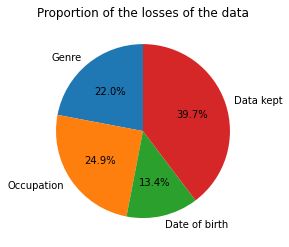

In [ ]:
gender_proportion = nb_diff_data_gender*100.0/nb_data_before
occupation_proportion = nb_diff_data_occupation*100.0/nb_data_before
date_of_birth_proportion = nb_diff_data_date_of_birth*100.0/nb_data_before
data_proportion = len(parquet)*100.0/nb_data_before

y = np.array([gender_proportion, occupation_proportion, date_of_birth_proportion,data_proportion])
labels = ["Genre", "Occupation", "Date of birth", "Data kept"]

plt.title('Proportion of the losses of the data')
plt.pie(y, labels = labels, startangle = 90, autopct='%1.1f%%')
plt.show() 

Here, we convert the colomn _Gender_ into what their Qcode mean. To do so, we use a dictionnary and an enum. Both help us, with an id array to translate quickely from a form to another.

In [ ]:
path_label = '/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
labels = pd.read_csv(path_label, compression='bz2')

In [ ]:
parquet["occupation_name"] = parquet.occupation

quids_redir = {'Q3268166': 'clinical psychologist', 'Q12014399': 'catholic priest', 'Q11819457': 'visual artist',
               'Q12334852': 'sailor', 'Q3186984': 'journalist', 'Q15991263': 'auctioneer', 'Q12455619': 'social worker',
               'Q1248362': 'director of a creative work', 'Q13365117': 'handball player', 'Q21550646': 'glass painter',
               'Q99753484': 'not found', 'Q6363085': 'advocate', 'Q16287483': 'opinion journalist', 'Q13424794': 'computational scientist',
               'Q11815360': 'pediatrician', 'Q5568256': 'forester'}

quids_enum = ['Q3268166','Q12014399', 'Q11819457','Q12334852','Q3186984','Q15991263','Q12455619',
               'Q1248362', 'Q13365117', 'Q21550646','Q99753484', 'Q6363085', 'Q16287483', 'Q13424794','Q11815360', 'Q5568256']

for i,occ in zip(tqdm(range(len(labels))),labels["QID"]):
  id = (parquet.occupation==occ)
  try:
    parquet.occupation_name[id] == labels.iloc["Label"][i]
  except KeyError:
    parquet.occupation_name=None

for i, occ in zip(tqdm(range(len(quids_enum))),quids_enum):
  id = (parquet.occupation==occ)
  try:
    parquet.occupation_name[id] == quids_redir[occ]
  except KeyError:
    parquet.occupation_name=None

if(parquet.occupation_name.isnull()) : 
  print('Id: '+parquet[parquet.occupation_name.isnull()].occupation+' was not found in label_descriptions')


In [ ]:
# Convert wiki ids to strings - v3
gender_dic =  {'Q1052281':    'transgender female', 
               'Q106299064':  'Erkek',
               'Q1097630':    'intersex',
               'Q1289754':    'neutrois',
               'Q12964198':   'genderqueer',
               'Q15145778':   'cisgender male',
               'Q15145779':   'cisgender female',
               'Q179294':     'eunuch',
               'Q18116794':   'genderfluid',
               'Q189125':     'transgender person',
               'Q1984232':    'shemale',
               'Q2449503':    'transgender male',
               'Q27679766':   'transmasculine',
               'Q301702':     'two-spirit',
               'Q3177577':    'muxe',
               'Q43445':      'female organism',
               'Q44148':      'male organism',
               'Q48270':      'non-binary',
               'Q48279':      'third gender',
               'Q505371':     'agender',
               'Q52261234':   'neutral sex',
               'Q6581072':    'female',
               'Q6581097':    'male',
               'Q6636':       'homosexuality',
               'Q7130936':    'pangender',
               'Q746411':     'kathoey',
               'Q859614':     'bigender',
               'Q93954933':   'demiboy',
               'Q96000630':   'X-gender'}

gender_enum = ['Q1052281','Q106299064','Q1097630','Q1289754','Q12964198','Q15145778','Q15145779',
               'Q179294','Q18116794','Q189125','Q1984232','Q2449503','Q27679766','Q301702','Q3177577',
               'Q43445','Q44148','Q48270','Q48279','Q505371','Q52261234','Q6581072','Q6581097',
               'Q6636','Q7130936','Q746411','Q859614','Q93954933','Q96000630']

for i, gender in zip(tqdm(range(len(gender_enum))),gender_enum):  #tqdm shows the timing of the process
  id = (parquet.gender==gender)
  try:
    parquet.gender[id] = gender_dic[gender]
  except KeyError:
        print('Id: '+gender+' was not found in label_descriptions')
  #print(parquet.gender[i])

Here is how our dataset finaly looks like.

In [ ]:
parquet.sample(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
8004760,None,+1969,[Q31],male,1288465041,None,None,[Q2309784],None,None,Q2794011,Koen De Koker,None,item,None
3777478,"[A. N. Baker, Alan Baker, Alan N. Baker]",+1940,[Q664],male,1322089493,None,None,"[Q350979, Q3640160, Q674426]",None,None,Q22105323,Alan Noel Baker,None,item,None
1526586,None,+1926,[Q30],male,1319771647,None,None,[Q49757],None,None,Q24256986,Ralph Salisbury,None,item,None
2636592,None,+1969,None,male,1367936713,None,None,[Q1028181],None,None,Q21485164,Chris Langlois,None,item,None
1176605,None,+1867,[Q183],male,1384237954,None,None,"[Q15983985, Q674426, Q5758653]",None,None,Q1309598,Otto Rubensohn,None,item,None


## Quotebank Dataset


First, we define our sort functions : process_probas and process_qchunk. 

The first one do is used to check if the probability of a speaker for a given quote is more than 70%. We chose that threshold because we want to avoid probabilities close to 0.5, because the odd to make a mistake is 1:1. We want to make sure that our speaker probability is not random. 
We use the second one to clean the data and form our final dataset.

In [ ]:
# Process_probas

def process_probas(speakers_probas): # In case the most probable speaker isn't the first one
  # Flatten probas into a single list
  flat = [item for sublist in speakers_probas for item in sublist]
  # Extract probs
  probas = [float(p) for i,p in enumerate(flat) if i%2]
  return (max(probas) > 0.7) # Return 1 if the max proba > 0.7



# Process_qchunk

def process_qchunk(chunk, path): # Quotebank chunk
  rem = []

  # Drop rows where speaker==None
  initial_n = len(chunk)
  chunk = chunk[chunk.speaker != 'None']
  rem.append(initial_n-len(chunk)) 

  # Keep only quotes with very probable speaker
  initial_n = len(chunk)
  chunk = chunk[chunk.probas.apply(process_probas)] 
  rem.append(initial_n-len(chunk))

  # Keep only numOcurrences > 0 ?
  initial_n = len(chunk)
  chunk = chunk[chunk.numOccurrences > 0]
  rem.append(initial_n-len(chunk))

  # Keep only qid size=1
  initial_n = len(chunk)
  chunk = chunk[chunk.qids.apply(lambda x: len(x)==1)]
  rem.append(initial_n-len(chunk))

  # Save to pickle
  with open(path, 'ab') as dest: # use pkl.load(dest) to recover **chunks**
    pkl.dump(chunk, dest)

  return rem

Here is where we extract the Quotebank dataset and use the functions defined above.

In [ ]:
# Processing by chunks
years = ['2020', '2019', '2018', '2017', '2016', '2015']

n_chunks = [0]*len(years)    # needed for read back
processing_steps = 4         # known speaker, very probable speaker, numOcurrences > 0, one single qid,
removed = np.zeros((len(years),processing_steps))
initial_n = [0]*len(years)

for i, year in zip(tqdm(range(len(years))), years):

  path_to_sfile = '/content/drive/MyDrive/ADA/Quotebank/quotes-'+year+'.json.bz2' 
  path_to_dfile = '/content/drive/MyDrive/ADA/quotes-'+year+'_processed.pkl' 

  df_reader = pd.read_json(path_to_sfile, lines=True, compression='bz2', chunksize=100000)
  for chunk in df_reader : 
    initial_n[i] += len(chunk)
    removed[i,:] += process_qchunk(chunk, path_to_dfile)
    n_chunks[i] += 1
  print(n_chunks)
  print('Year: {}  Inital number of samples: {}  Removed: {}  Total: {} '.format(year, initial_n[i], removed[i,:],
                                                                                 removed[i,:].sum()))

Here is a visualisation of the process of our data.

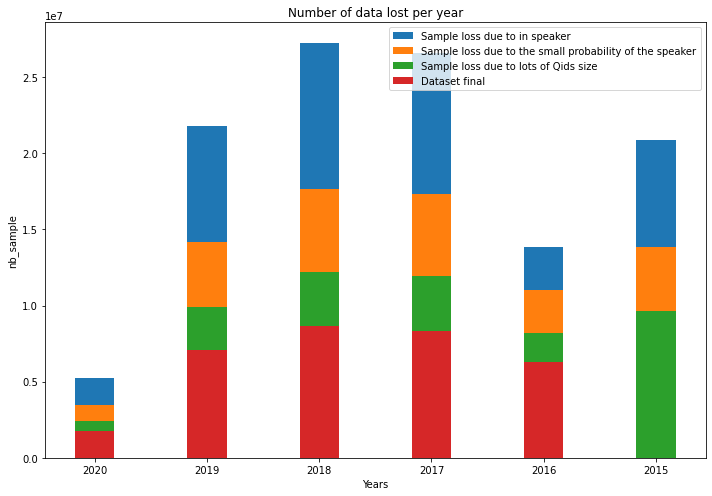

In [7]:
init_nb_sample = [5244449, 21763302, 27228451, 26611588, 13862129, 20874338]
nb_sample_none_speaker = [3443605, 14183294, 17670419, 17333298, 11035434, 13858038]
nb_sample_prob_speaker = [2419648, 9875076, 12185447, 11948347, 8208739, 9663107]
nb_sample_qid_size = [1743841, 7076288, 8623990, 8329693, 6286262, 0]
years = ['2020', '2019', '2018', '2017', '2016', '2015']

ind = np.arange(len(init_nb_sample))

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.bar(x=ind, height=init_nb_sample, width=0.35, align='center', label = 'Sample loss due to in speaker')
ax.bar(x=ind, height=nb_sample_none_speaker, width=0.35, align='center', label = 'Sample loss due to the small probability of the speaker')
ax.bar(x=ind, height=nb_sample_prob_speaker, width=0.35, align='center', label = 'Sample loss due to lots of Qids size')
ax.bar(x=ind, height=nb_sample_qid_size, width=0.35, align='center', label = 'Dataset final')


plt.xticks(ind, years)
plt.title('Number of data lost per year')
plt.legend()
plt.xlabel('Years')
plt.ylabel('nb_sample')
plt.tight_layout()
plt.show()

We can see that 2020 has much less quotes than the other yers, moreover, we see that we keep a third of our original data for our project.

We then extract the name of the author of the articles using the urls.


In [ ]:
# importing name-gender dataset
df_names = pd.read_csv('/content/drive/MyDrive/ADA/project/name_gender_dataset.csv')
df_names = df_names[['Name', 'Gender']]
df_names

In [ ]:
# checking dataset
print(df_names.Name.isnull().sum(), df_names.Gender.isnull().sum())
print((df_names.Gender=='M').sum(), (df_names.Gender=='F').sum())
print(((df_names.Gender=='M').sum()+(df_names.Gender=='F').sum())==len(df_names))

In [ ]:
# feature extractor
def gender_features(word):
  return {'last_letter':word[-1],
          'last_2letters':word[-2:]}

We use a naive Bayes classifier from NLTK to obtain the gender of the author.

In [ ]:
# preparing a list of examples and corresponding class labels.
labeled_names = [(name, gender) for (name, gender) in zip(df_names.Name, df_names.Gender)]

# we use the feature extractor to process the names data.
featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names]

# Divide the resulting list of feature
# sets into a training set and a test set.
train_set, test_set = train_test_split(featuresets, test_size=0.25)

clf = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(clf, train_set))
print(nltk.classify.accuracy(clf, test_set))

In [ ]:
# Extracts one author name (if found) for each url (if valid)                   11min for 188 quote samples
def extract_authors(urls): # Using newspaper3k, try & except because link may be not valid (404 etc.)
  names = []               # We could use status code of request otherwise 
  for link in urls:
    article = Article(link)
    try: 
      article.download()
      article.parse()
      article.nlp()
    except:
      names.append('Invalid link')
    else:
      authors = article.authors # could be empty (author not found or article restricted to members-only, ex: http://sunshinecoastdaily.com.au/news/incredible-upside-to-horn-vs-tszyu-bloody-sunday-d/3974224/)
      if len(authors)==0:
        names.append(None)
      else:
        names.append(authors[0]) # with [0], it doesn't handle the case when there are several authors  but avoids getting a lot of extra stuff that aren't names    
  return names


def gender_from_name(names):
  # names can contain None, invalid link or (complete) names
  # classifier clf used as global because unable to pass it as argument when using .apply(func,args=(clf))
  genders = []
  for name in names:
    if (name==None) or (name=='Invalid link'):
      genders.append(None)
    else:
      sub = name.split(' ')
      firstname = sub[0]
      if len(firstname) > 1: # to safely extract features
        genders.append(clf.classify(gender_features(firstname)))
      else:
        genders.append(None)
  
  return genders



def process_qchunk2(chunk, path, parquet):
  # Merge with parquet
  initial_n = len(chunk)
  chunk.qids = chunk.qids.apply(lambda x: x[0]) # Extract qid string
  # Keep the label of the parquet to uniform the names of the speaker
  chunk = chunk.merge(parquet, left_on='qids', right_on='id').drop(labels = ["speaker", "qids"],axis=1)
  
  # extract authors
  chunk['authors'] = chunk.urls.apply(extract_authors)
  # extract author gender
  chunk['author_gender'] = chunk.authors.apply(gender_from_name)
  rem = initial_n-len(chunk)
  
  # Save to pickle
  with open(path, 'ab') as dest: # use pkl.load(dest) to recover **chunks**
    pkl.dump(chunk, dest)

  return rem

In [ ]:
n_chunks = []
M = [0]*len(years) 
F = [0]*len(years) 
removed = [0]*len(years)  # by merge

for i,year in enumerate(years):

  path_to_sfile = '/content/drive/MyDrive/quotes-'+year+'_processed.pkl' 
  path_to_dfile = '/content/drive/MyDrive/quotes-'+year+'_processed_merged.pkl' 
  
  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[i]):
      chunk = pkl.load(f)
      process_qchunk2(chunk, path_to_dfile, parquet)
      F[i] += chunk['gender'].value_counts().sort_index()[0]
      M[i] += chunk['gender'].value_counts().sort_index()[1]
    
    
x = np.arange(len(years))  # the years locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, M, width, label='Men')
rects2 = ax.bar(x + width/2, F, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Count by year and gender')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()

plt.show()

## Start of the analysis


In [ ]:
# Start of the analysis of the data
years = ['2020', '2019', '2018', '2017', '2016', '2015']

n_chunks = [0]*len(years)    # needed for read back
processing_steps = 5         # known speaker, very probable speaker, numOcurrences > 0, one single qid, merge
removed = np.zeros((len(years),processing_steps))
initial_n = [0]*len(years)

for i,year in enumerate(years):

  path_to_sfile = '/content/drive/MyDrive/ADA/quotes-'+year+'_processed.pkl' 
  
  for chunk in pd.read_pickle(path_to_sfile, lines=True, compression='bz2', chunksize=500000):
    F += chunk['gender'].values_counts().sort_index()[0]
    M += chunk['gender'].values_counts().sort_index()[1]
  plt.pie([F, M], labels=[women, men], normalize=True)

